# Modelisation of a radiative condenser using water as a refrigerant

Description - Motivation

In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

import CoolProp.CoolProp as CP

## PDRC study

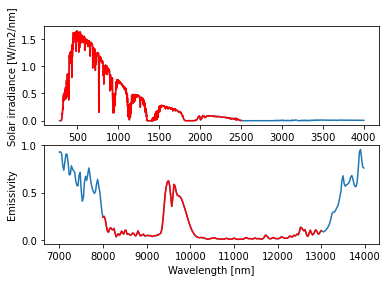

In [183]:
#Constant
h = 6.62e-34 #J.s
c = 3e8 #m/s
kb = 1.38e-23 #J/K
Tamb = 20+273.15 #K
em = 0.98 #emittance
R = 0.98 #reflectance
hair = 0 #W/m2/K (convective flux)

#Importation of atmospheric data
df = pd.read_excel(r"AtmosphericData.xlsx")
df8_13 = df[df['WaveL']>=8][df[df['WaveL']>=8]['WaveL']<=13] #select the values between 8 and 13 microns
waveL = np.array([lamb*1e3 for lamb in df8_13['WaveL']]) #nm
EmAtm = np.array([em for em in df8_13['Em']])

#Importation of solar data
df2 = pd.read_excel(r'SolarData.xlsx')
df2.head()
df300_2500 = df2[df2['WaveL']>=300][df2[df2['WaveL']>=300]['WaveL']<=2500] #select the values between 0.3 and 2.5 microns
waveLsun = np.array([lamb for lamb in df300_2500['WaveL']]) #nm
Isun = np.array([I for I in df300_2500['GlobalTilt']]) #W/m2/nm

#Plot
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(df2['WaveL'],df2['GlobalTilt'])
ax1.plot(waveLsun,Isun,'red')
ax1.set_ylabel('Solar irradiance [W/m2/nm]')

ax2.plot(df['WaveL']*1e3,df['Em'])
ax2.plot(waveL,EmAtm,'red')
ax2.set_xlabel('Wavelength [nm]')
ax2.set_ylabel('Emissivity');

Not yet found atmospheric data within 4-30 microns so we will stay with a PDRC in the 8-13 window for the tests
$\dot{Q}_{net}(T_w) = \pi \Bigg( \int_{8\mu m}^{13} \Big( I_{BB}(\lambda,T_w)\epsilon - I_{BB}(\lambda,T_{amb})\epsilon_{atm}(\lambda) \Big)d\lambda - \int_{0.3 \mu m}^{2.5\mu m}  \big( 1-R\big) I_{solar}(\lambda) d\lambda \Bigg) - h_{air}(T_{amb}-T_w)$

with $I_{BB} (T,\lambda)=\frac{2hc^2}{\lambda^5 (exp⁡(\frac{hc}{k_B \lambda T})-1)}$

In [184]:
def Ibb(T,lamb): #W/m/nm
    # lamb is in m
    return (2*h*c**2/(lamb**5*(np.exp(h*c/(kb*lamb*T))-1)))*1e-9

def Q_PDRC(Tc,Tamb=Tamb,kb=kb,h=h,c=c): #Tc in K
    Rad = Ibb(Tc,waveL*1e-9)*em-Ibb(Tamb,waveL*1e-9)*EmAtm #W/m2/nm (radiation/atm spectrum within 8-13 microns)
    Intrad = integrate.simpson(Rad,waveL)
    Sun = (1-R)*Isun #W/m2/nm (solar spectrum within 0.3 and 2.5 microns)
    Intsun = integrate.simpson(Sun,waveLsun)
    Nonrad = hair*(Tamb-Tc)
    return np.pi*(Intrad-Intsun) -Nonrad#W/m2

Text(0.5, 1.0, 'Estimation of the flux created by the PDRC in function of the wall temperature')

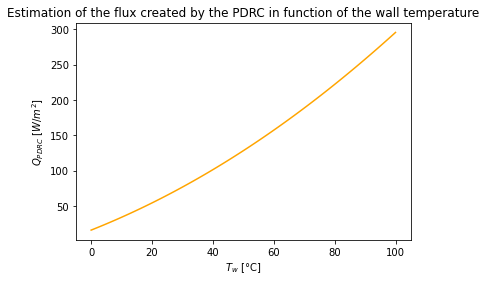

In [185]:
Tc = np.linspace(0,100,100)
y = [Q_PDRC(T+273.15) for T in Tc]
plt.plot(Tc,y,color = 'orange')
plt.xlabel('$T_w$ [°C]')
plt.ylabel('$Q_{PDRC} \ [W/m^2]$')
plt.title('Estimation of the flux created by the PDRC in function of the wall temperature')

The result is in accordance to the one in the paper.

### Estimation over the inverse function

Linearisation of the relation between the heat flux and the condenser temperature is made to simplify the estimation over the inversed function.

At the end an other method will be used

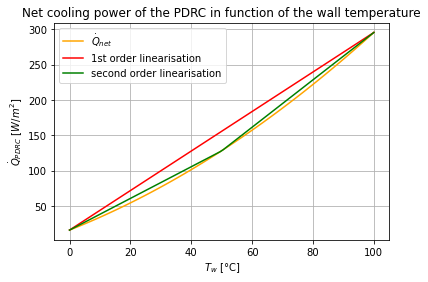

In [210]:
Tc = np.linspace(0,100,100)
y = [Q_PDRC(T+273.15) for T in Tc]
#Linerarisation 1er ordre
a = (np.max(y)-np.min(y))/(np.max(Tc)-np.min(Tc))
b = np.max(y)-a*np.max(Tc)
ylin = a*Tc+b
#linearisation second ordre
a2 = (np.max(y[:50])-np.min(y[:50]))/(np.max(Tc[:50])-np.min(Tc[:50]))
b2 = np.max(y[:50])-a2*np.max(Tc[:50])
a2b = (np.max(y[50:])-np.min(y[50:]))/(np.max(Tc[50:])-np.min(Tc[50:]))
b2b = np.max(y[50:])-a2b*np.max(Tc[50:])
ylin2 = np.concatenate((a2*Tc[:50]+b2,a2b*Tc[50:]+b2b))
# Def inversed function 2nd order
def Twc(Q): #K
    if Q<= np.max(y[:50]):
        return (Q-b2)/a2
    else:
        return (Q-b2b)/a2b+273.15

#Plot
plt.plot(Tc,y,'orange', label='$\dot{Q}_{net}$')
plt.plot(Tc,ylin,'red',label = '1st order linearisation')
plt.plot(Tc,ylin2,'green',label = 'second order linearisation')
plt.xlabel('$T_w$ [°C]')
plt.ylabel('$\dot{Q}_{PDRC} \ [W/m^2]$')
plt.title('Net cooling power of the PDRC in function of the wall temperature')
plt.legend()
plt.grid()
#plt.savefig("PDRC.png",dpi=200)
plt.show()

## Modelisation of the system

###  First model (en cours)

In this model, we consider the following geometry: a one channel tube discretized in mesh where the gaz goes one way and liquid can accumulate in the tube (or not if the inclinaison is enough: this will be taken into in the angle and the void rate).

In [188]:
#Fluid parameters
mwater = 3.5/100 #kg/s
Tin = 65+273.15 #K
Pin = CP.PropsSI('P','T',Tin,'Q',1,'water');print(f'P_in = {Pin} Pa') #Pa
Hin= CP.PropsSI('H','P',Pin,'Q',1,'water')
#Hin= CP.PropsSI('H','P',Pin,'T',Tin,'water')
Tamb = 20+273.15 #K
Tspace = 3 #K

#Geometry
Lmax = 1#m (length of the tube)
ni = 1000 #number of mesh
dx = Lmax/ni;print(f'dx ={dx*1e3} mm') #m (elementary length)
et = 0.5 #m (tube height)
w = 1 #m #tube width
e = 1.1e-3 #m (tube thickness)
theta = np.pi/10 #rad (angle d'inclinaison)
condt = 239 #W/m/K (thermal conductivity of the material: aluminium)
G = mwater/(w*et) #m/s (water speed)
Dh = 4*w*et/(2*(w/et)); #m (hydraulic diameter)
K=0.4
Rein = G*Dh*CP.PropsSI('D','T',Tin,'Q',1,'water')/CP.PropsSI('V','T',Tin,'Q',1,'water');print(f'entry Re = {Rein}') #Rel = min(Rel,Reg)

#Constant
sig = 5.67e-8 #W/m2/K4

P_in = 25041.598084684127 Pa
dx =1.0 mm
entry Re = 512.6269134540312


In [189]:
#Gives the Reynold for either liquid or gas phase at saturation or Re_l in general
def Reyn(v,L,p,H=None,ph=2): 
    if ph==0: #liquid
        return v*L*CP.PropsSI('D','P',p,'Q',0,'water')/CP.PropsSI('V','P',p,'Q',0,'water')
    if ph==1: #gas
        return v*L*CP.PropsSI('D','P',p,'Q',1,'water')/CP.PropsSI('V','P',p,'Q',1,'water')
    return v*L*CP.PropsSI('D','P',p,'H',H,'water')/CP.PropsSI('V','P',p,'H',H,'water')

#zeta Muller
def zeta(Re): 
    if Re < 1187:
        return 64/Re
    return 0.3164*Re**(1/4)

#Void rate
def alpha(x,ro_gaz,ro_l): 
    gamm = K+(1-K)*((ro_l/ro_gaz+K*(1-x)/max(1e-7,x))/(1+K*(1-x)/max(1e-7,x)))**0.5
    return 1/(1+(1-x)/max(1e-7,x)*ro_gaz/ro_l*gamm)

#Model
def Model(mwater=mwater,Pin=Pin,Hin=Hin,Tin=Tin,theta=theta,
          Lmax=Lmax,h=h,w=w,dx=dx):
    #Init
    P,H,T,Tw,dPG,dPdyn,dPfr,hv,hr,x,AL = [Pin],[Hin],[Tin],[Tin],[0],[0],[0],[],[],[1],[1]
    G ,Dh = mwater/(w*h), 4*w*h/(2*(w/h))
    for i in range(1,ni): # loop for each mesh
        #internal exchange coefficient calculation
        NuL = 0.023*Reyn(G,Dh,P[-1],ph=0)**0.8*CP.PropsSI('Prandtl','P',P[-1],'Q',0,'water')**0.3; #Nussel liquid
        if x[-1]>=1 or x[-1]<=1e-7:    #If monophasic
            Numono = 0.023*Reyn(G,Dh,P[-1],H=H[-1])**0.8*CP.PropsSI('Prandtl','P',P[-1],'H',H[-1],'water')**0.3
            h = CP.PropsSI('L','P',P[-1],'H',H[-1],'water')/Dh*Numono
        else:
            Pred = P[-1]/CP.PropsSI('Pcrit','water') #reduced pressure
            NuShah = NuL*((1-x[-1])**0.8+3.8*x[-1]**0.76*(1-x[-1])**0.04/Pred**0.38)                                                  
            h = CP.PropsSI('L','P',P[-1],'H',H[-1],'water')/Dh*NuShah
        hv.append(h)
        #external radiative exchange coefficient
        hr.append(Q_PDRC(Tw[-1])/(Tw[-1]-Tamb)/(2*dx*(w+et)))
        #hair = 38
        #Calculation of the flux
        Q = 1/(e/condt/(dx*2*(w+et))+1/h/(dx*2*(w+et))+1/hr[-1]/(2*dx*(w+et)))*(T[-1]-Tamb)
        #Deduce the delta enthalpy
        dH = Q/mwater
        H.append(H[-1]-dH)
        #Deduce Temperatures
        T.append(CP.PropsSI('T','P',P[-1],'H',H[-1],'water'))
        Tw.append(Twc(Q))
        #Deduce the vapour title
        x.append(max(min(1,CP.PropsSI('Q','P',P[-1],'H',H[-1],'water')),0)) #must stay between 0 and 1
        #Pressure losses du to friction
        #ro_gaz = min(CP.PropsSI('D','P',P[-1],'Q',1,'water'),CP.PropsSI('D','H',H[-1],'P',P[-1],'water')) #the density must not go lower than gas
        ro_gaz = CP.PropsSI('D','H',H[-1],'P',P[-1],'water')
        ro_liq = CP.PropsSI('D','P',P[-1],'Q',0,'water')
        A = zeta(Reyn(G,Dh,P[-1],ph=0))*mwater**2/2/ro_liq/Dh
        B = zeta(Reyn(G,Dh,P[-1],ph=1))*mwater**2/2/ro_gaz/Dh 
        #B = zeta(Reyn(G,Dh,P[-1],H=H[-1])*mwater**2/2/ro_gaz/Dh
        Ge = A+2*(B-A)*x[-1]
        dP = dx*(Ge*x[-1]**(1/3)+B*x[-1]**3)
        #dP = dx*(Ge*(1-x[-1])**(1/3)+B*x[-1]**3) #code leviathan
        #Dynamical pressure losses
        #use ro_gaz?
            #downstream cell
        AL.append(alpha(x[-1],ro_gaz,ro_liq))
        Pdyn1 = G**2*x[-1]**2/ro_liq/max(1e-7,AL[-1]) + G**2*(1-x[-1])**2/ro_liq/(1-min((1-1e-7),AL[-1])) #max(1e-7,AL[-1])
            #upstream cell
        Pdyn0 = G**2*x[-2]**2/ro_liq/max(1e-7,AL[-2]) + G**2*(1-x[-2])**2/ro_liq/(1-min((1-1e-7),AL[-2]))
        #Gravitational pressure losses
        dPg = dx*((1-AL[-1])*ro_liq+AL[-1]*ro_gaz)*9.81*np.sin(theta)
        dPG.append(dPg)
        dPdyn.append(max(5,min(5,Pdyn0-Pdyn1))) #;print(Pdyn0-Pdyn1)
        dPfr.append(max(5,min(5,dP))) #;print(dP)
        P.append(P[-1]-(dPfr[-1]+dPG[-1]-dPdyn[-1]))
    return T,Tw,P,x,AL,hv,hr,dPfr,dPdyn,dPG

In [190]:
T,Tw,P,x,AL,hv,hr,dPfr,dPdyn,dPG = Model()

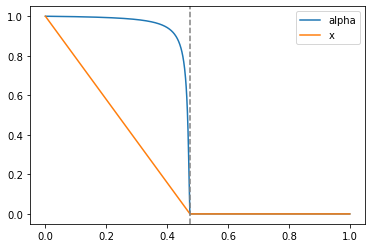

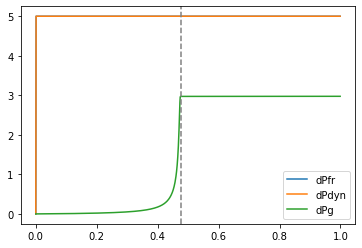

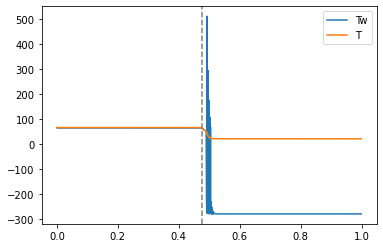

In [191]:
Len = np.array(range(0,ni))*dx
#Plot the line x == 0
plt.plot(Len,AL,label='alpha')
plt.plot(Len,x,label='x')
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')
plt.legend()
plt.show()
plt.plot(Len,dPfr,label = 'dPfr')
plt.plot(Len,dPdyn,label = 'dPdyn')
plt.plot(Len,dPG, label = 'dPg')
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')
plt.legend()
plt.show()
plt.plot(Len,np.array(Tw)-273.15 ,label ='Tw')
plt.plot(Len,np.array(T)-273.15, label = 'T')
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')
plt.legend()

2) The plot are the same while changing the Lmax (only the abscisse change)

2) Value of pressure are too important 1e+90 for DPfr and 1e+58 dPdyn: constraining them lower than 5 is not helping

**Look at the different component of the flux**

hv = [4.146279110119738e+38,1.3510030380526415e+42] W/m2/K
hcond = 217272.72727272726 W/m2/K
hr = [86.41652747328989,21817.76243387041] W/m2/K


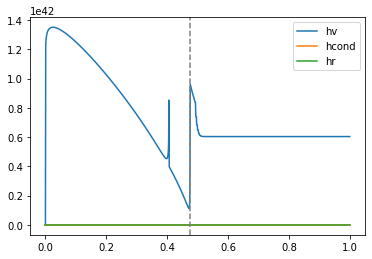

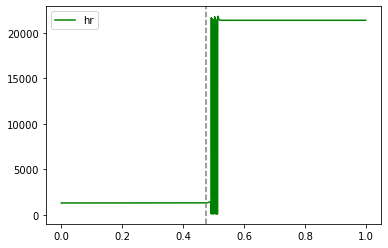

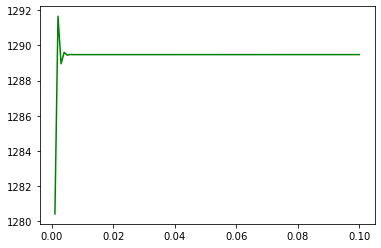

In [192]:
plt.plot(Len[1:],hv,label = 'hv');print(f'hv = [{np.min(hv)},{np.max(hv)}] W/m2/K')
hcond = condt/e*np.ones(ni-1)
plt.plot(Len[1:],hcond,label = 'hcond');print(f'hcond = {hcond[0]} W/m2/K')
plt.plot(Len[1:],hr,label = 'hr');print(f'hr = [{np.min(hr)},{np.max(hr)}] W/m2/K')
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')
plt.legend()
plt.show()
#Plot only hr
plt.plot(Len[1:],hr,'green',label = 'hr')
plt.axvline(x=Len[(np.array(x)<1e-7)][0],color='gray',linestyle='--')
plt.legend();
#Zoom hr before x=0
plt.show()
plt.plot(Len[1:101],hr[:100],'green',label = 'hr')
#This evolution is the same for Tw at the begining

They don't have the same order of magnitude: hv is too important and thus 1/hv negligable in front of 1/hr:
- 1/hv is too small and is neglected
- hr does not vary much before x=0